In [1]:
## https://www.kaggle.com/jrw2200/smart-pricing-with-xgb-rfr-interpretations

In [2]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

sns.set(rc={'figure.figsize':(10,8)})

## Load data

In [3]:
data = pd.read_csv('./../data/kaggle/AB_NYC_2019.csv')

In [4]:
data.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [6]:
print("No of features: {}".format(data.shape[1]))
print("No of examples: {}".format(data.shape[0]))

No of features: 16
No of examples: 48895


In [7]:
len(data.host_id.unique())

37457

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
id                                48895 non-null int64
name                              48879 non-null object
host_id                           48895 non-null int64
host_name                         48874 non-null object
neighbourhood_group               48895 non-null object
neighbourhood                     48895 non-null object
latitude                          48895 non-null float64
longitude                         48895 non-null float64
room_type                         48895 non-null object
price                             48895 non-null int64
minimum_nights                    48895 non-null int64
number_of_reviews                 48895 non-null int64
last_review                       38843 non-null object
reviews_per_month                 38843 non-null float64
calculated_host_listings_count    48895 non-null int64
availability_365                  48895 non-null int64

In [9]:
data['last_review'] = pd.to_datetime(data['last_review'],infer_datetime_format=True) 

## Preprocessing and EDA

## 1.0 Missing data
Many machine learning algorithms do badly when acting on inputs with missing data. To deal with this, we start by taking a count of missing values in each column.

In [10]:
pd.Series(data.isnull().sum()/data.shape[0] * 100, name='missing').sort_values(ascending=False)

reviews_per_month                 20.558339
last_review                       20.558339
host_name                          0.042949
name                               0.032723
availability_365                   0.000000
calculated_host_listings_count     0.000000
number_of_reviews                  0.000000
minimum_nights                     0.000000
price                              0.000000
room_type                          0.000000
longitude                          0.000000
latitude                           0.000000
neighbourhood                      0.000000
neighbourhood_group                0.000000
host_id                            0.000000
id                                 0.000000
Name: missing, dtype: float64

In [11]:
data[data['number_of_reviews']== 0.0].shape

(10052, 16)

The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place.

For reviews_per_month, I will fill those values with 0's.

In [12]:
data.reviews_per_month.fillna(0, inplace=True)

In [13]:
earliest = min(data['last_review'])
data['last_review'] = data['last_review'].fillna(earliest)
data['last_review'] = data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [14]:
pd.Series(data.isnull().sum()/data.shape[0] * 100, name='missing').sort_values(ascending=False)

host_name                         0.042949
name                              0.032723
availability_365                  0.000000
calculated_host_listings_count    0.000000
reviews_per_month                 0.000000
last_review                       0.000000
number_of_reviews                 0.000000
minimum_nights                    0.000000
price                             0.000000
room_type                         0.000000
longitude                         0.000000
latitude                          0.000000
neighbourhood                     0.000000
neighbourhood_group               0.000000
host_id                           0.000000
id                                0.000000
Name: missing, dtype: float64

### 1.2 Choosing a prediction target [Smart Pricing Regressor]
One of the machine learning models at AirBNB is Smart Pricing. After a client has entered the details of their rental, AirBNB suggests an appropriate price. The aim of this notebook is to build and train a Smart Pricing model for this dataset.

### 1.3 Price distribution
I notice that the target has a highly skewed distribution. This can cause problems for machine learning algorithms such as linear regression. A log transformation and removal of outliers makes the distribution look much closer to normal.



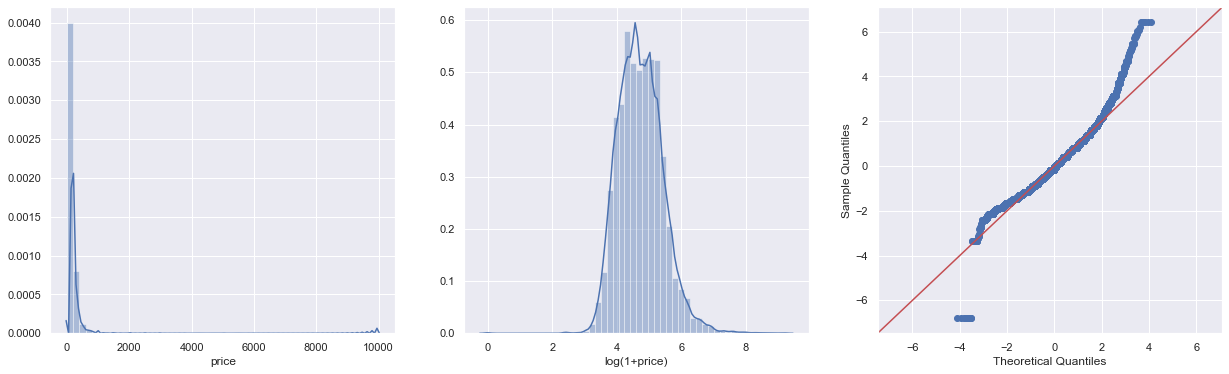

In [15]:
import numpy as np
import statsmodels
import statsmodels.api as sm
import scipy.stats as stats

fig, axes = plt.subplots(1,3, figsize=(21,6))

sns.distplot(data['price'], ax=axes[0])

sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [16]:
data = data[(np.log1p(data['price']) < 8) & (np.log1p(data['price']) > 3)]

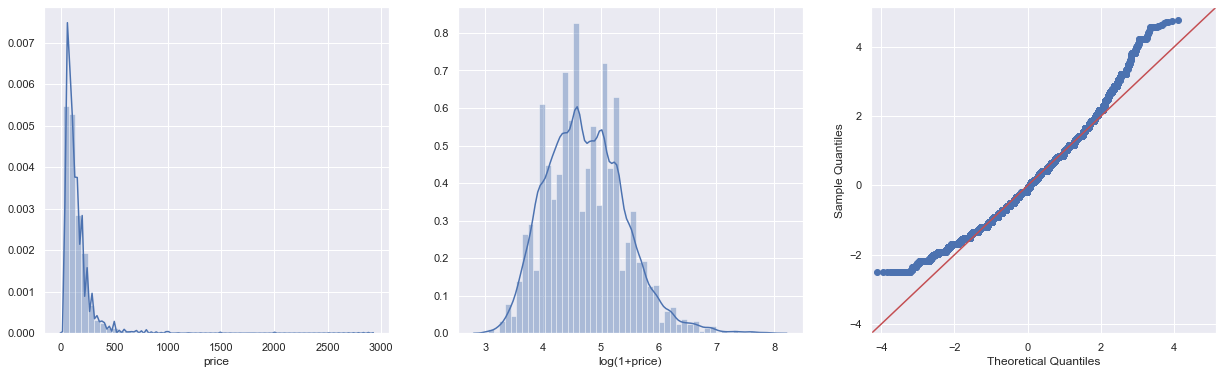

In [17]:
fig, axes = plt.subplots(1,3, figsize=(21,6))

sns.distplot(data['price'], ax=axes[0])

sns.distplot(np.log1p(data['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')

sm.qqplot(np.log1p(data['price']), stats.norm, fit=True, line='45', ax=axes[2]);

In [18]:
data['price'] = np.log1p(data['price'])

## 1.4. Predictor distributions

### 1.4.0 A list of predictors

In [19]:
print(data.columns)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


### 1.4.1 Host_id

In [20]:
print('In this dataset there are {} unique hosts renting out a total number of {} properties.'.format(len(data['host_id'].unique()), data.shape[0]))

In this dataset there are 37384 unique hosts renting out a total number of 48784 properties.


Since the number of unique hosts is close to the total number of examples, we're not going to use hostname in our regression analysis since it would cause the number of parameters in our model to baloon!

In real-life, when there is more data and perhaps some feature data on hosts, I expect past history of a host and of a property to be a strong predictor of price!

In [21]:
data = data.drop(['host_id', 'id'], axis=1)

### 1.4.2 Neighbourhood group
I notice that Statten Island and the Bronx are highly underrepresented in this dataset. For Statten Island, the reason is that the population of the island is small. However, this can't be the case for the Bronx which has a population comparable (~1.4mln) to Manhattan (~1.6mln) or for for Brooklyn /Queens with their populations of ~2.5mln and ~2.4mln, respectively.

This makes sense: Queens, the Bronx and, to a fair extent Brooklyn, are residential neighborhoods unlike Manhattan which is a business centre as well as a tourist destination.

In [22]:
data.neighbourhood_group.unique()

array(['Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

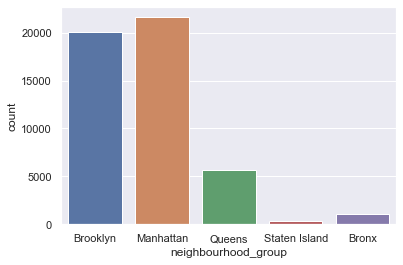

In [23]:
sns.countplot(data=data, x='neighbourhood_group');

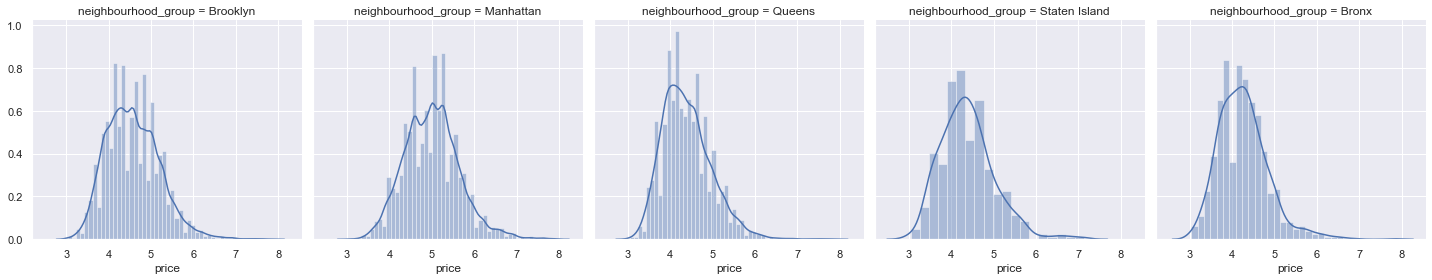

In [24]:
g = sns.FacetGrid(data, col='neighbourhood_group', height=4);
g = g.map(sns.distplot, "price");

### 1.4.3 Longitude and latitude
Longitude and latitude are somewhat correlated with each other. This is because the locations of properties tend to come from clusters.

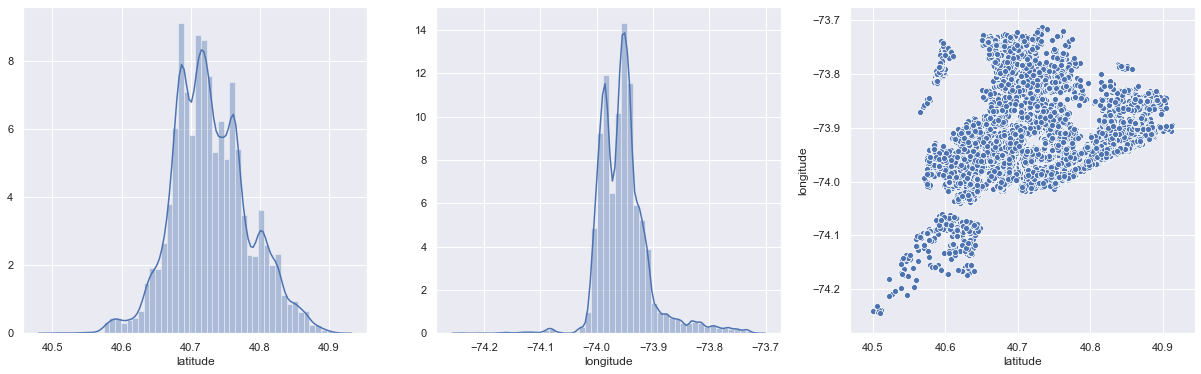

In [25]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(data['latitude'], ax=axes[0])
sns.distplot(data['longitude'], ax=axes[1])
sns.scatterplot(x= data['latitude'], y=data['longitude']);

### 1.4.4 Room type
As far as room types, this dataset is balanced away from 'Shared room' properties. The proportions of private room and entire home/apt rentals are close, with entire home/apt dominating prive room by <10%.

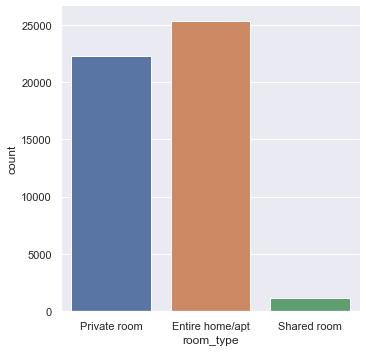

In [26]:
sns.catplot(x='room_type', kind='count', data=data);

### 1.4.5 Minimum nights

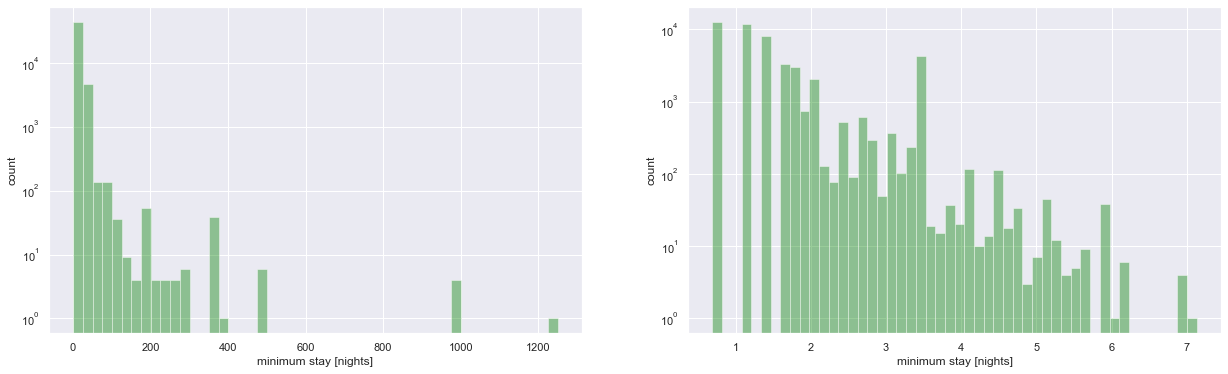

In [27]:
fig, axes = plt.subplots(1,2, figsize=(21, 6))

sns.distplot(data['minimum_nights'], rug=False, kde=False, color="green", ax = axes[0])
axes[0].set_yscale('log')
axes[0].set_xlabel('minimum stay [nights]')
axes[0].set_ylabel('count')

sns.distplot(np.log1p(data['minimum_nights']), rug=False, kde=False, color="green", ax = axes[1])
axes[1].set_yscale('log')
axes[1].set_xlabel('minimum stay [nights]')
axes[1].set_ylabel('count');

In [28]:
data['minimum_nights'] = np.log1p(data['minimum_nights'])

### 1.4.6 Reviews per month

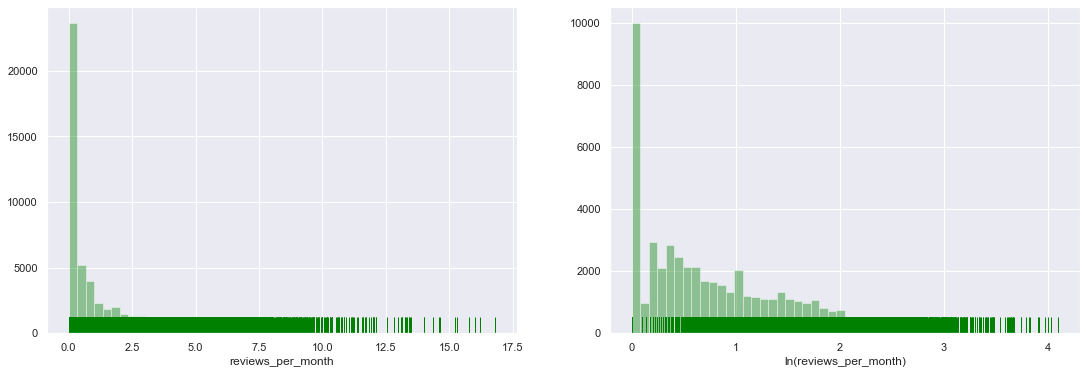

In [29]:
fig, axes = plt.subplots(1,2,figsize=(18.5, 6))

sns.distplot(data[data['reviews_per_month'] < 17.5]['reviews_per_month'], rug=True, kde=False, color="green", ax=axes[0])

sns.distplot(np.sqrt(data[data['reviews_per_month'] < 17.5]['reviews_per_month']), rug=True, kde=False, color="green", ax=axes[1])
axes[1].set_xlabel('ln(reviews_per_month)');

The distribution of the number of reviews per month is highly skewed however way we cut it. This is because there is a large weight on small numbers: there are a lot of properties which only get a few reviews and a rather fat tail of properties which get a lot of reviews.

One explanation would be that the properties which are available a larger fraction of the year get more reviews. However, a scatter plot of reviews_per_month and availability_365 variables shows no evidence of a relationship so that explanation would appear to not be valid.

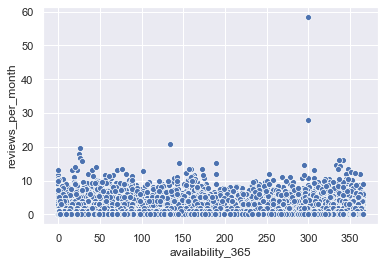

In [30]:
sns.scatterplot(x=data['availability_365'], y=data['reviews_per_month']);

In [31]:
data['reviews_per_month'] = data[data['reviews_per_month'] < 17.5]['reviews_per_month']

### 1.4.7 Availability_365
This distribution is highly skewed towards the low and high end. The dataset contains a hiuge number of properties that are available only for a couple of days each year, and a decent number that are available for > 300 days.

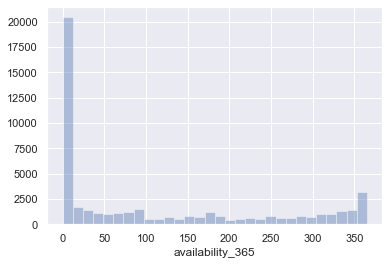

In [32]:
sns.distplot(data.availability_365, rug=False, kde=False,);

In [ ]:
#### Feature engineering

In [66]:
data['all_year_avail'] = data['availability_365'] > 353
data['low_avail'] = data['availability_365'] < 12
data['no_reviews'] = data['reviews_per_month'] == 0

In [33]:
neighbourhood_df = data.pivot_table(['price', 'number_of_reviews', 'calculated_host_listings_count'] , ['neighbourhood'], aggfunc='mean').reset_index()

In [34]:
neighbourhood_df.head()

,neighbourhood,calculated_host_listings_count,number_of_reviews,price
0,Allerton,2.761905,42.928571,4.286647
1,Arden Heights,1.000000,7.750000,4.190475
2,Arrochar,4.190476,14.619048,4.377341
3,Arverne,1.662338,29.259740,4.840898
4,Astoria,2.774194,21.477197,4.488385


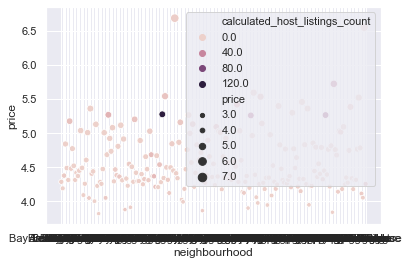

In [35]:
fig = sns.scatterplot(data=neighbourhood_df, x='neighbourhood', y='price', hue='calculated_host_listings_count', size='price');
#fig.set_xtickslabel(roation=90);

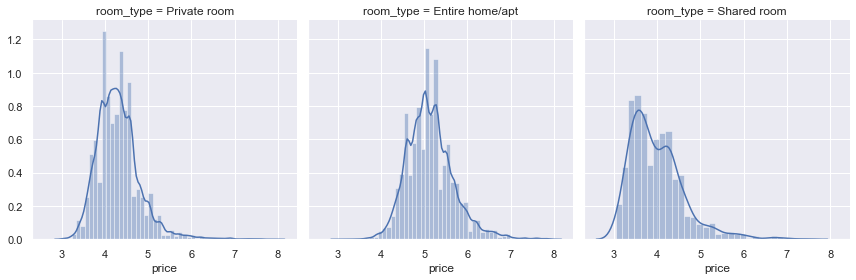

In [36]:
g = sns.FacetGrid(data, col='room_type', col_wrap=3, height=4);
g = g.map(sns.distplot, "price");

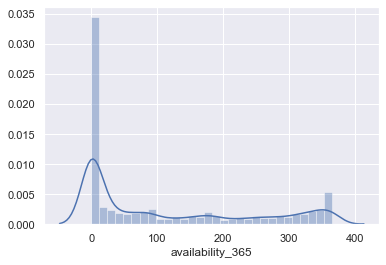

In [37]:
sns.distplot(data.availability_365);

In [38]:
def plot_by_roomtype_min_nights(room_type):
    filtered = data.query('room_type == @room_type')["minimum_nights"]
    sns.swarmplot(x=filtered.values, y=filtered.index);
    plt.xticks(rotation=90)

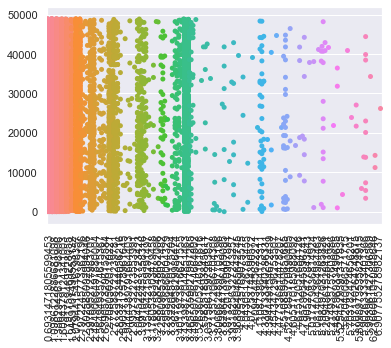

In [39]:
plot_by_roomtype_min_nights('Private room');

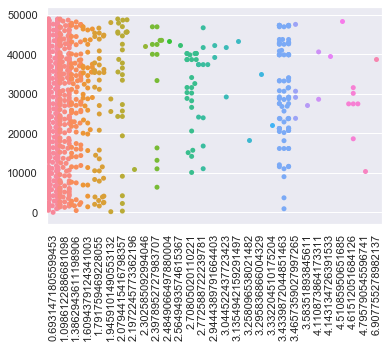

In [40]:
plot_by_roomtype_min_nights('Shared room');

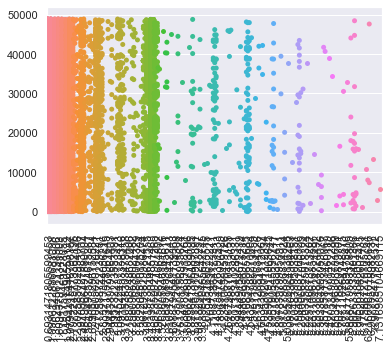

In [41]:
plot_by_roomtype_min_nights('Entire home/apt');

In [42]:
data['price'].groupby(data['neighbourhood_group']).describe()

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1089.0,4.262284,0.584992,3.044522,3.828641,4.189655,4.605170,7.824446
Brooklyn,20067.0,4.577750,0.625343,3.044522,4.110874,4.510860,5.017280,7.873598
Manhattan,21603.0,5.002770,0.649713,3.044522,4.564348,5.017280,5.398163,7.972811
Queens,5654.0,4.388283,0.578866,3.044522,3.931826,4.330733,4.709530,7.863651
Staten Island,371.0,4.380716,0.636701,3.044522,3.931826,4.330733,4.705005,7.131699


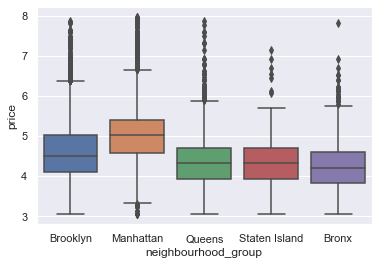

In [43]:
sns.boxplot(data.neighbourhood_group, data.price);

In [45]:
def plot_price_dist(data, by, hist=False):
    for v in data[by].unique():
        sns.distplot(data.loc[data[by] == v]['price'], hist=hist, label=v);

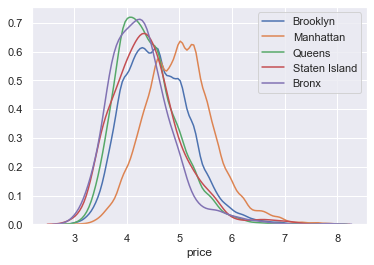

In [67]:
plot_price_dist(data, 'neighbourhood_group')

In [47]:
data['price'].groupby(data['room_type']).describe()

,count,mean,std,min,25%,50%,75%,max
room_type,,,,,,,,
Entire home/apt,25344.0,5.143145,0.542331,3.044522,4.795791,5.081404,5.438079,7.972811
Private room,22296.0,4.310287,0.501686,3.044522,3.931826,4.262680,4.564348,7.955425
Shared room,1144.0,3.990160,0.629779,3.044522,3.555348,3.828641,4.330733,7.496097


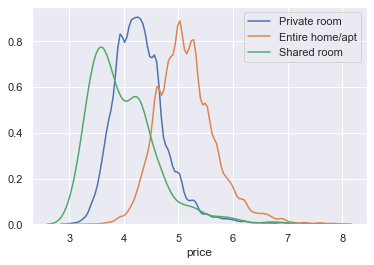

In [68]:
plot_price_dist(data, 'room_type')

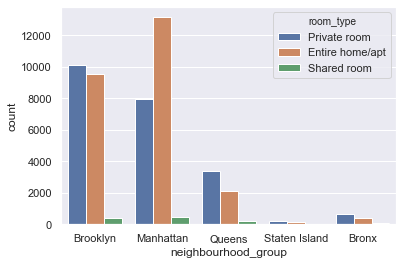

In [49]:
sns.countplot(data=data, x='neighbourhood_group', hue='room_type');

In [50]:
data[['neighbourhood_group', 'price']].groupby('neighbourhood_group')['price'].apply(list).apply(lambda x: pd.Series(x).describe())

,count,mean,std,min,25%,50%,75%,max
neighbourhood_group,,,,,,,,
Bronx,1089.0,4.262284,0.584992,3.044522,3.828641,4.189655,4.605170,7.824446
Brooklyn,20067.0,4.577750,0.625343,3.044522,4.110874,4.510860,5.017280,7.873598
Manhattan,21603.0,5.002770,0.649713,3.044522,4.564348,5.017280,5.398163,7.972811
Queens,5654.0,4.388283,0.578866,3.044522,3.931826,4.330733,4.709530,7.863651
Staten Island,371.0,4.380716,0.636701,3.044522,3.931826,4.330733,4.705005,7.131699


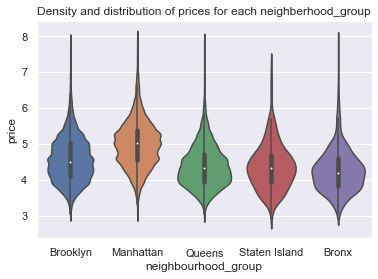

In [51]:
sns.violinplot(data=data.query('price < 500'), x='neighbourhood_group', y='price');
plt.title('Density and distribution of prices for each neighberhood_group');

In [52]:
count_by_neighbourhood = data.neighbourhood.value_counts().to_frame().reset_index()
count_by_neighbourhood.columns=['neighbourhood', 'count']

In [53]:
count_by_neighbourhood.head(10)

,neighbourhood,count
0,Williamsburg,3917
1,Bedford-Stuyvesant,3704
2,Harlem,2654
3,Bushwick,2458
4,Upper West Side,1960
5,Hell's Kitchen,1954
6,East Village,1850
7,Upper East Side,1793
8,Crown Heights,1563
9,Midtown,1544


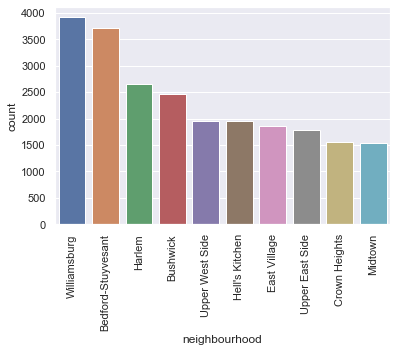

In [54]:
top10_count_by_neighbourhood = count_by_neighbourhood.head(10)
sns.barplot(data=top10_count_by_neighbourhood, x='neighbourhood', y='count');
plt.xticks(rotation=90);

In [55]:
top10_neigbourhood_data = data.query('neighbourhood in @top10_count_by_neighbourhood.neighbourhood')

In [56]:
top10_neigbourhood_data.head()

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
1,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,45,2976,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0,0,0.00,1,365
6,BlissArtsSpace!,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,4.110874,3.828641,49,2383,0.40,1,0
7,Large Furnished Room Near B'way,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,4.382027,1.098612,430,3010,3.47,1,220
8,Cozy Clean Guest Room - Family Apt,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,4.382027,1.098612,118,2307,0.99,1,0


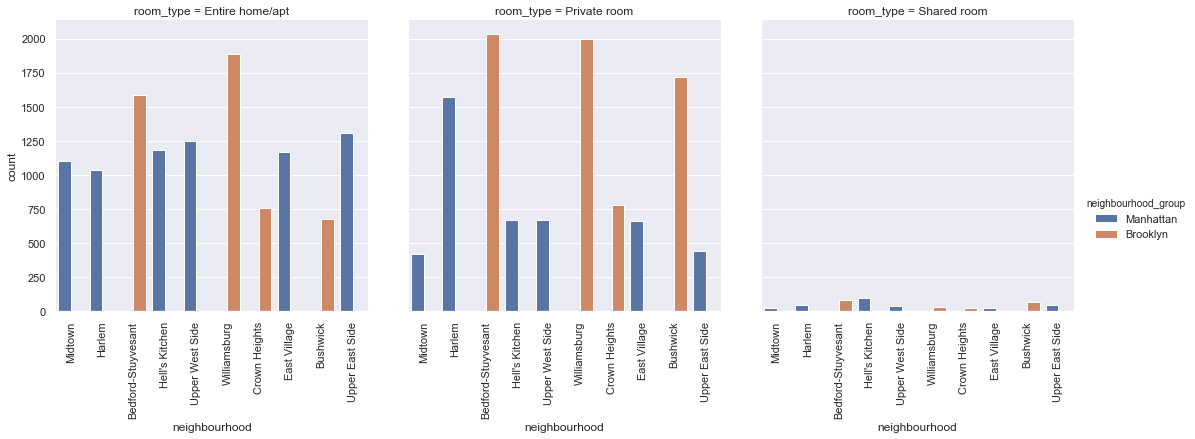

In [57]:
fig = sns.catplot(data=top10_neigbourhood_data, x='neighbourhood', hue='neighbourhood_group', col='room_type', kind='count');
fig.set_xticklabels(rotation=90);

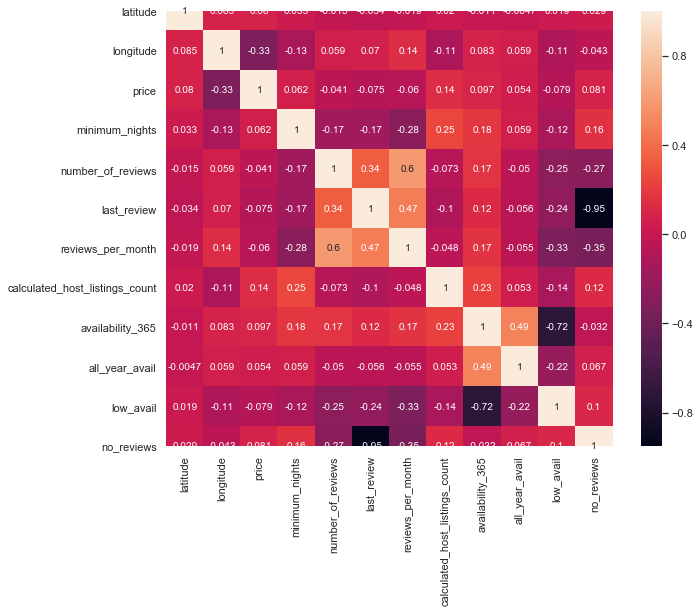

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, ax=ax);

### The variable price is very weak correlated with the other numerical variables.

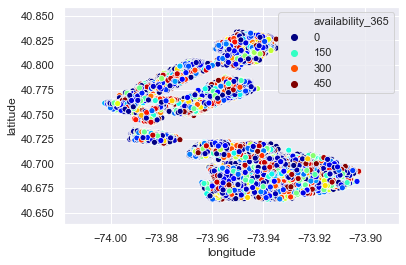

In [59]:
sns.scatterplot(data=top10_neigbourhood_data, x='longitude', y='latitude', hue='availability_365',
                      palette=plt.get_cmap('jet'));

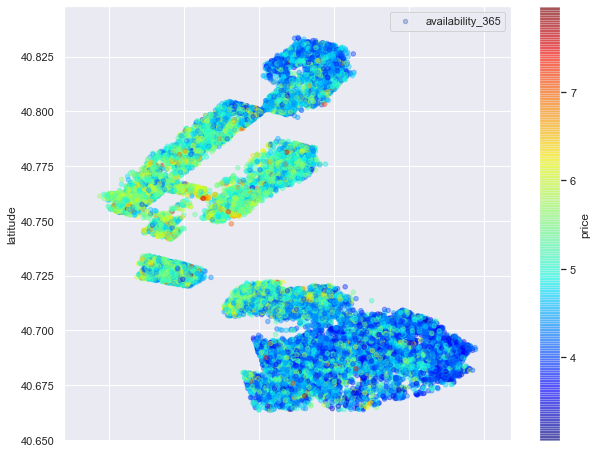

In [60]:
viz_4=top10_neigbourhood_data.plot(kind='scatter', x='longitude', y='latitude', label='availability_365', c='price',
                  cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, figsize=(10,8))
viz_4.legend();

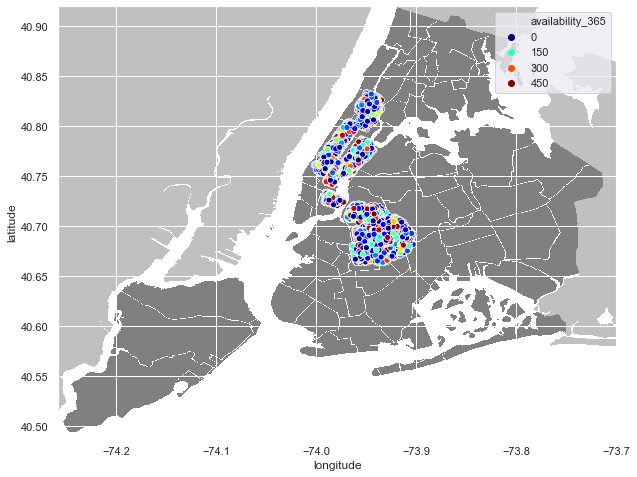

In [61]:
import urllib
#initializing the figure size
plt.figure(figsize=(10,8))
#loading the png NYC image found on Google and saving to my local folder along with the project
i=urllib.request.urlopen('https://upload.wikimedia.org/wikipedia/commons/e/ec/Neighbourhoods_New_York_City_Map.PNG')
nyc_img=plt.imread(i)

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

sns.scatterplot(data=top10_neigbourhood_data, x='longitude', y='latitude', hue='availability_365',
                      palette=plt.get_cmap('jet'), ax=ax);
plt.legend()
plt.show()

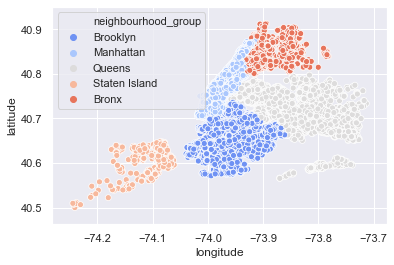

In [62]:
sns.scatterplot(y=data.latitude,x=data.longitude,hue=data.neighbourhood_group,palette="coolwarm");

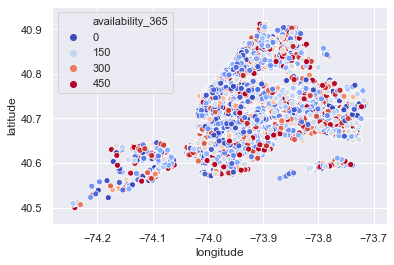

In [63]:
sns.scatterplot(y=data.latitude,x=data.longitude,hue=data.availability_365,palette="coolwarm");

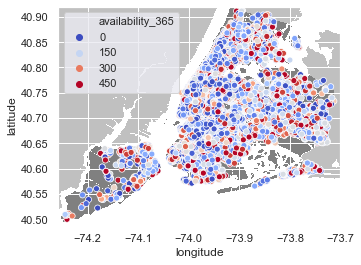

In [64]:
plt.imshow(nyc_img, zorder=0, extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

sns.scatterplot(y=data.latitude,x=data.longitude,hue=data.availability_365,palette="coolwarm", ax=ax);
plt.legend()
plt.show()

In [65]:
# import folium
# from folium.plugins import HeatMap

# m = folium.Map([40.7128,-74.0060],zoom_start=11)
# HeatMap(data[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(m)
# display(m)